In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import GlobalAveragePooling2D,Dropout,BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from scipy.optimize import minimize

2024-04-18 13:58:12.272646: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 13:58:12.272787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 13:58:12.407652: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.2)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator

In [3]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [4]:
def initiateModel1(noOfClasses):
    modelInput = tf.keras.applications.MobileNetV3Small(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def initiateModel(noOfClasses):
    modelInput = tf.keras.applications.MobileNetV3Small(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    #x = Dense(128, activation='relu')(x)
    #x = BatchNormalization()(x)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def initiateModel2(noOfClasses):
    modelInput = tf.keras.applications.MobileNetV3Small(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = GlobalAveragePooling2D()(modelInput.output)
    #x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    prediction = Dense(noOfClasses, activation='softmax')(x)
    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [5]:
def initiateModel3(noOfClasses):
    modelInput_vgg16 = tf.keras.applications.VGG16(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    for layer in modelInput_vgg16.layers:
        layer.trainable = False

    # Load and freeze MobileNetV3Small model
    modelInput_mobilenet = tf.keras.applications.MobileNetV3Small(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    for layer in modelInput_mobilenet.layers:
        layer.trainable = False

    # Load and freeze EfficientNetB0 model
    modelInput_efficientnet = tf.keras.applications.EfficientNetB0(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    for layer in modelInput_efficientnet.layers:
        layer.trainable = False

    # Concatenate the outputs of the base models
    concatenated_features = Concatenate()([modelInput_vgg16.output, modelInput_mobilenet.output, modelInput_efficientnet.output])

    # Apply global average pooling
    global_avg_pool = GlobalAveragePooling2D()(concatenated_features)

    # Dense layer
    dense_layer = Dense(128, activation='relu')(global_avg_pool)
    batch_norm = BatchNormalization()(dense_layer)

    # Output layer
    output = Dense(noOfClasses, activation='softmax')(batch_norm)

    # Create model
    model = Model(inputs=[modelInput_vgg16.input, modelInput_mobilenet.input, modelInput_efficientnet.input], outputs=output)
    
    return model




In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Concatenate

def initiateModelConcatenated(noOfClasses):
    # Define input layers for each model
    input_vgg16 = tf.keras.Input(shape=IMAGE_SIZE + [3])
    input_mobilenet = tf.keras.Input(shape=IMAGE_SIZE + [3])
    input_efficientnet = tf.keras.Input(shape=IMAGE_SIZE + [3])

    # Load and freeze VGG16 model
    modelInput_vgg16 = tf.keras.applications.VGG16(
        include_top=False,
        weights="imagenet"
    )(input_vgg16)
    for layer in modelInput_vgg16.layers:
        layer.trainable = False

    # Load and freeze MobileNetV3Small model
    modelInput_mobilenet = tf.keras.applications.MobileNetV3Small(
        include_top=False,
        weights="imagenet"
    )(input_mobilenet)
    for layer in modelInput_mobilenet.layers:
        layer.trainable = False

    # Load and freeze EfficientNetB0 model
    modelInput_efficientnet = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet"
    )(input_efficientnet)
    for layer in modelInput_efficientnet.layers:
        layer.trainable = False

    # Global average pooling and dense layer for each model
    x_vgg16 = tf.keras.layers.GlobalAveragePooling2D()(modelInput_vgg16)
    x_vgg16 = tf.keras.layers.Dense(128, activation='relu')(x_vgg16)
    x_vgg16 = tf.keras.layers.BatchNormalization()(x_vgg16)

    x_mobilenet = tf.keras.layers.GlobalAveragePooling2D()(modelInput_mobilenet)
    x_mobilenet = tf.keras.layers.Dense(128, activation='relu')(x_mobilenet)
    x_mobilenet = tf.keras.layers.BatchNormalization()(x_mobilenet)

    x_efficientnet = tf.keras.layers.GlobalAveragePooling2D()(modelInput_efficientnet)
    x_efficientnet = tf.keras.layers.Dense(128, activation='relu')(x_efficientnet)
    x_efficientnet = tf.keras.layers.BatchNormalization()(x_efficientnet)

    # Concatenate the outputs of all models
    concatenated_output = Concatenate()([x_vgg16, x_mobilenet, x_efficientnet])

    # Final prediction layer
    prediction = tf.keras.layers.Dense(noOfClasses, activation='softmax')(concatenated_output)

    # Define the model with multiple inputs and single output
    model = tf.keras.Model(inputs=[input_vgg16, input_mobilenet, input_efficientnet], outputs=prediction)

    return model


In [7]:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
    ]
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=METRICS)
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + 'MobileNet.keras', verbose=1, save_best_only=True)
    
    return model, annealer, checkpoint



In [8]:
def modelFit1(model, annealer, checkpoint):

    history = model.fit(
      [train_generator,train_generator,train_generator],
      validation_data=([validation_generator, validation_generator, validation_generator], None),
      epochs=gEpochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history

In [9]:
def modelFit(model, annealer, checkpoint):

    train_data = []
    validation_data = []

    for i in range(len(train_generator)):
        train_data_batch, train_labels_batch = next(train_generator[i])
        train_data.append(train_data_batch)
    train_data = np.concatenate(train_data)

    for i in range(len(validation_generator)):
        validation_data_batch, validation_labels_batch = next(validation_generator[i])
        validation_data.append(validation_data_batch)
    validation_data = np.concatenate(validation_data)

    train_labels = np.concatenate([train_labels_batch for _, train_labels_batch in train_generator[0]])
    validation_labels = np.concatenate([validation_labels_batch for _, validation_labels_batch in validation_generator[0]])

    history = model.fit(
        train_data,
        train_labels,
        validation_data=(validation_data, validation_labels),
        epochs=gEpochs,
        batch_size=batchSize,
        callbacks=[annealer, checkpoint],
        steps_per_epoch=len(train_generator[0]),
        validation_steps=len(validation_generator[0])
    )
    
    return history

In [10]:
def modelFit1(model, train_generator_vgg16, train_generator_mobilenet, train_generator_efficientnet, 
             validation_generator_vgg16, validation_generator_mobilenet, validation_generator_efficientnet,
             annealer, checkpoint):
    history = model.fit(
        [train_generator_vgg16, train_generator_mobilenet, train_generator_efficientnet],  # Pass three generators for each input
        validation_data=([validation_generator_vgg16, validation_generator_mobilenet, validation_generator_efficientnet], None),  # No validation labels are needed here
        epochs=gEpochs,
        batch_size=batchSize,
        callbacks=[annealer, checkpoint],
        steps_per_epoch=len(train_generator_vgg16),
        validation_steps=len(validation_generator_vgg16)
    )
    return history


In [11]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [12]:
def evalModel(model):
    evl = model.evaluate(validation_generator)
    acc = evl[7]*100
    TP = evl[1]
    FP = evl[2]
    FN = evl[4]
    TN = evl[3]
    prec = evl[5]
    rec = evl[6]
    F1 = 100 * ((2 * prec * rec) / (prec + rec))
    auc = evl[8]
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    msg+=f'\nTrue Positives = {TP}. True Negatives = {TN}'
    msg+=f'\nFalse Positives = {FP}. False Negatives = {FN}'
    msg+=f'\nPrecision = {prec}'
    msg+=f'\nRecall = {rec}'
    msg+=f'\nF1 Score = {F1}'
    msg+=f'\nROC AUC = {auc}'
    print(msg)
    
def saveModel(model, className):
    model.save(className + " - MobileNetV3.keras")
    print("Model Saved!")

In [13]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [14]:
def callPlot(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")
    def objective_function(hyperparameters):
        lr,batch = hyperparameters
        accuracy = accuracy_score(y_true,y_pred)
        return -accuracy
    
    accuracy = accuracy_score(y_true, y_pred)
    search_space = [(1e-4, 1e-2), (32, 256)]
    result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')
    best_hyperparameters = result.x
    print("Best Hyperparameters (learning rate, batch size):", best_hyperparameters)

In [15]:
mpath = r'/kaggle/input/multi-cancer/Multi Cancer'
classPaths = os.listdir(mpath)
IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 10
batchSize = 256
lr = 0.001

for i in classPaths:
    print(i)
    

Cervical Cancer
Lung and Colon Cancer
Oral Cancer
ALL
Kidney Cancer
Breast Cancer
Lymphoma
Brain Cancer



Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 20000 images belonging to 5 classes.

For Val :  Found 5000 images belonging to 5 classes.

No of Classes :  5
Classes :  ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
Image Shape :  (32, 256, 256, 3)
16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization (Normaliza

TypeError: 'tuple' object is not an iterator

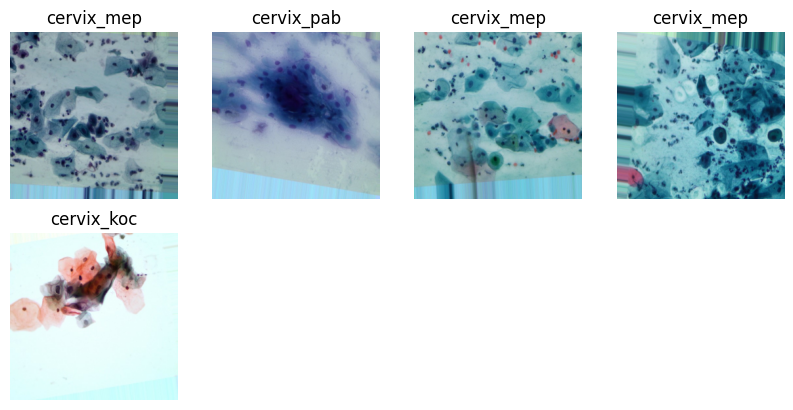

In [16]:
className = 'Cervical Cancer '
cpath = os.path.join(mpath, 'Cervical Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel3(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)

In [ ]:
className = 'Lung And Colon Cancer '
cpath = os.path.join(mpath, 'Lung and Colon Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)

In [ ]:
className = 'Oral Cancer '
cpath = os.path.join(mpath, 'Oral Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel2(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)

In [ ]:
className = 'ALL'
cpath = os.path.join(mpath, 'ALL')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)

In [ ]:
className = 'Kidney Cancer '
cpath = os.path.join(mpath, 'Kidney Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)

In [ ]:
className = 'Breast Cancer '
cpath = os.path.join(mpath, 'Breast Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)

In [ ]:
className = 'Lymphoma '
cpath = os.path.join(mpath, 'Lymphoma')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)

In [ ]:
className = 'Brain Cancer '
cpath = os.path.join(mpath, 'Brain Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)